Objective:
Segement cars and humans in a given picture


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil 
shutil.unpack_archive('/content/drive/MyDrive/CV/new_data_distr.zip', "new_data_distr/")

# Introduction

For this project I will use pre-trained model UNet. UNet is a famous pre-trained model used to predict masks. This model is a autoencoder which the initial layers learn the low-level concepts such as edges and colors and the later level layers learn the higher level concepts such as different objects [[1]](https://nanonets.com/blog/how-to-do-semantic-segmentation-using-deep-learning/). 
I used a extense pre-procesing as the data with the masks were not in good resulution. For the model itself, I used [this tutorial](https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch) to implemented. I thougth this is a good implementation for this problem as in the tutorial they used as data image taken by drones. Also, I had some problems running the model in my computer as I had problems with my graphic card and can not use cuda. Because of that I used colab that has a time limit if you are using GPU.


# Preprocesing

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm


Upload the files and create path variables

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
# direcotories

# for drive
root_p = 'new_data_distr'
data_path = os.path.join(root_p, 'new_data_distr')
# for comp
#data_path = os.getcwd() + '/cityscapes_data'

train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'val')

In [5]:
print(train_path)

new_data_distr/new_data_distr/train


Look at the images

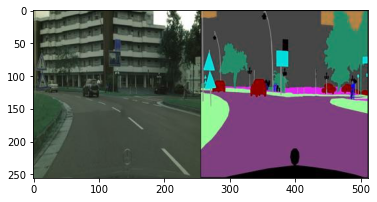

In [7]:
plt.imshow(cv2.imread(os.path.join(train_path, '1.jpg')))

Separate the images as images and masks, as now they are mixed in the same image. And put them in the respective files, one for the image itself and another for the mask image (as this would be needed for upload the dataset for UNet)

In [6]:
new_data_path = root_p + '/new_data_distr'
new_train_path = os.path.join(new_data_path, 'train')
new_test_path = os.path.join(new_data_path, 'val')

In [ ]:
# only one execution

# create directories for the data

os.mkdir(new_data_path)
os.mkdir(new_train_path)
os.mkdir(new_test_path)

os.mkdir(os.path.join(new_train_path, 'img'))
os.mkdir(os.path.join(new_train_path, 'mask'))
os.mkdir(os.path.join(new_test_path, 'img'))
os.mkdir(os.path.join(new_test_path, 'mask'))

In [ ]:
# only one execution

# separate images
def split_img(path_v):
    img = cv2.imread(path_v)
    # int(img.shape[1]/2) # not used because all the images are the same size
    return img[:,:256], img[:,256:]

# write the images in their respective folder
def write_imgs(prev_path, new_path):
    paths = os.listdir(prev_path)
    for i in paths:
        img, mask = split_img(os.path.join(prev_path, i))
        cv2.imwrite(os.path.join(new_path, 'img', i), img)
        cv2.imwrite(os.path.join(new_path, 'mask', i), mask)

### To work with UNet, it is needed that the mask is in one dimension, so I change the mask to numbers

In [ ]:
img = cv2.imread(os.path.join(new_train_path+ '/mask', '3.jpg'))
img

array([[[ 10,   8,   0],
        [ 17,  21,  10],
        [  0,   8,   0],
        ...,
        [  1,   1,   1],
        [ 18,  18,  18],
        [  0,   0,   0]],

       [[ 24,  41,  28],
        [ 72,  92,  79],
        [ 63,  94,  79],
        ...,
        [ 49,  49,  49],
        [ 56,  56,  56],
        [ 26,  26,  26]],

       [[  0,  40,  22],
        [ 82, 128, 109],
        [ 81, 138, 117],
        ...,
        [ 76,  76,  76],
        [ 73,  73,  73],
        [ 32,  32,  32]],

       ...,

       [[ 42,  13,  46],
        [102,  71, 104],
        [106,  74, 109],
        ...,
        [115,  75, 116],
        [113,  73, 114],
        [ 59,  19,  60]],

       [[ 43,  21,  45],
        [ 77,  55,  79],
        [ 77,  52,  78],
        ...,
        [ 80,  49,  82],
        [ 81,  50,  83],
        [ 40,   9,  42]],

       [[ 13,   0,  15],
        [ 26,  10,  28],
        [ 17,   0,  17],
        ...,
        [ 21,   0,  22],
        [ 43,  15,  44],
        [ 25,   0,  26]]

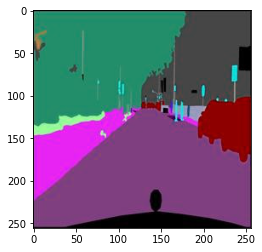

In [ ]:
plt.imshow(img)

In [6]:
# the image is not in good resolution, so we check the pixels
ii = test_mask_imgs_np[4]
for i in ii:
    for j in i:
        print(j)

We can see that the colors of the pixels varies a lot, which is different of the mask expectation. Also the colors of each group (cars, trees, persons, etc) are unknow. I find [this discussion](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/discussion/80753) in the kaggle forum, which has a link to a github repository that shows the colors and a way of change the image to stable colors. I copy past the label vector and with that I created a "colors" dictionary with the name of the label and the color.

In [5]:
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


In [ ]:
# creation of colors_dict dictionary
# creation of colors vector
# the colors are on the last index, and the tuples are backwards
# for the rgb format
colors_dict = {}
colors_v = []
for i in labels:
    colors_dict[i[0]] = [i[-1][2], i[-1][1], i[-1][0]]
    colors_v.append([i[-1][2], i[-1][1], i[-1][0]])

In [ ]:
colors_dict

{'unlabeled': [0, 0, 0],
 'ego vehicle': [0, 0, 0],
 'rectification border': [0, 0, 0],
 'out of roi': [0, 0, 0],
 'static': [0, 0, 0],
 'dynamic': [0, 74, 111],
 'ground': [81, 0, 81],
 'road': [128, 64, 128],
 'sidewalk': [232, 35, 244],
 'parking': [160, 170, 250],
 'rail track': [140, 150, 230],
 'building': [70, 70, 70],
 'wall': [156, 102, 102],
 'fence': [153, 153, 190],
 'guard rail': [180, 165, 180],
 'bridge': [100, 100, 150],
 'tunnel': [90, 120, 150],
 'pole': [153, 153, 153],
 'polegroup': [153, 153, 153],
 'traffic light': [30, 170, 250],
 'traffic sign': [0, 220, 220],
 'vegetation': [35, 142, 107],
 'terrain': [152, 251, 152],
 'sky': [180, 130, 70],
 'person': [60, 20, 220],
 'rider': [0, 0, 255],
 'car': [142, 0, 0],
 'truck': [70, 0, 0],
 'bus': [100, 60, 0],
 'caravan': [90, 0, 0],
 'trailer': [110, 0, 0],
 'train': [100, 80, 0],
 'motorcycle': [230, 0, 0],
 'bicycle': [32, 11, 119],
 'license plate': [142, 0, 0]}

In [ ]:
# as we have some colors repeated:
import itertools
colors_v.sort()
colors_v = list(colors_v for colors_v,_ in itertools.groupby(colors_v))

# we convert colors_v to numpy
colors_v = np.array(colors_v)
colors_v

array([[  0,   0,   0],
       [  0,   0, 255],
       [  0,  74, 111],
       [  0, 220, 220],
       [ 30, 170, 250],
       [ 32,  11, 119],
       [ 35, 142, 107],
       [ 60,  20, 220],
       [ 70,   0,   0],
       [ 70,  70,  70],
       [ 81,   0,  81],
       [ 90,   0,   0],
       [ 90, 120, 150],
       [100,  60,   0],
       [100,  80,   0],
       [100, 100, 150],
       [110,   0,   0],
       [128,  64, 128],
       [140, 150, 230],
       [142,   0,   0],
       [152, 251, 152],
       [153, 153, 153],
       [153, 153, 190],
       [156, 102, 102],
       [160, 170, 250],
       [180, 130,  70],
       [180, 165, 180],
       [230,   0,   0],
       [232,  35, 244]])

With the dictionary, I iterate in the mask images and:
1. Compute the distance between the pixel and each color of the color dictionary
    - For this, we use[ euclidean distances from numpy](https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy)
2. Selec the color from the dictionary that is closer to the pixel
3. Replace the original pixel with the near color

In [ ]:
# we check the max distance
print(np.linalg.norm(np.array([0,0,0]) - np.array([255, 255, 255])))

441.6729559300637


In [ ]:
def img_fixed_colors(img_v):
    img = img_v
    for i in range(256):
        for j in range(256):
            dist = 500
            color = [0,0,0]
            # calculate the distance between each color and the pixel
            for c in colors_v:
                if(np.linalg.norm(img[i][j] - c) < dist):
                    dist = np.linalg.norm(img[i][j] - c)
                    color = c
            img[i][j] = color
    return img

Check if img_fixed_colors works

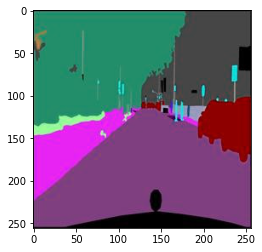

In [ ]:
plt.imshow(img)

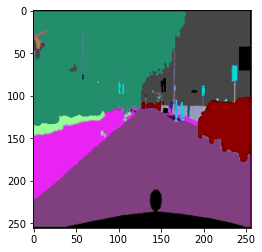

In [ ]:
plt.imshow(img_fixed_colors(img))

As it is needed only to segmentate cars and humans, the other colors should not appear.
img_fixed_selected_colors convert the mask to 1-dimention image and only with the colors of the selected

In [ ]:
#list of colors that will stay in the mask img
                # black # car     # human person   # human rider 
good_colors = [[0,0,0], [142, 0, 0],[60, 20, 220],[0,0,205]]


def img_fixed_selected_colors(img):
    new_mask = np.zeros((256,256))
    for i in range(256):
        for j in range(256):
            dist = 500
            color = [0,0,0]
            # calculate the distance between each color and the pixel
            for c in colors_v:
                if(np.linalg.norm(img[i][j] - c) < dist):
                    dist = np.linalg.norm(img[i][j] - c)
                    color = c

            for id_gc, gc in enumerate(good_colors):
                if (color == gc).all():
                    new_mask[i][j] = id_gc
                    break
    return new_mask
            # else: it would be 0 (default)

Check if img_fixed_selected_colors works

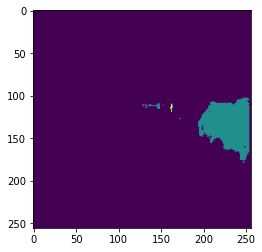

In [ ]:
plt.imshow(img_fixed_selected_colors(img))

Create a function that saves the mask images with the colors wanted in another folder

In [ ]:
def fixed_colors_and_save(prev_path, new_path):
    paths = os.listdir(prev_path)
    for i in paths:
        mask = cv2.imread(os.path.join(prev_path, i))
        nmask = (img_fixed_selected_colors(mask))
        cv2.imwrite(os.path.join(new_path, i[:-4] + '.png'), nmask)

In [ ]:
# only one execution
os.mkdir(os.path.join(new_train_path, 'newmask'))
os.mkdir(os.path.join(new_test_path, 'newmask'))

As this function takes a lot of time (if we have the train (2975) and the val (500)), I use a parallism code in c++ to perform a python script. You can find these codes in [this drive](https://drive.google.com/drive/folders/1NZqhj62pTMe1suqK3el_dF4bKqt6cUU4?usp=sharing). The python script has a function that aplies img_fixed_selected_colors for a range of images (as the name of the mask images are numbers). It works with 8 threads, as my computer has 4 cores that allows 2 threads each core(hyperthreading).

The next lines are a example of one function being used without paralelim

In [ ]:
fixed_colors_and_save(os.path.join(new_test_path, 'mask'), os.path.join(new_test_path, 'newmask'))

The new data used is in [this drive](https://drive.google.com/file/d/1kC7hbiX61nytSSWEA-EGAKz__1-mKxc-/view?usp=sharing). It has newmask added and you can uziped with: 
```
shutil.unpack_archive("/content/drive/MyDrive/CV/new_data_distr.zip", "new_data_distr/")
```

In [7]:
!pip install -q albumentations

In [8]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import albumentations as A

In [9]:
# upload data set
class myDataset(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path 
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_path, self.X.iloc[idx][0] + '.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_path,self.X.iloc[idx][0] + '.png'), cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [10]:
n_classes = 4 

def create_df(path_v):
    name = []
    dir_v = os.path.join(path_v, 'img')
    for dirname, _, filenames in os.walk(dir_v):
        for filename in filenames:
            name.append(str(filename.split('.')[0]))
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df(new_train_path)
df2 = create_df(new_test_path)
print('Total Images: ', len(df))
print('Total Images: ', len(df2))

Total Images:  2975
Total Images:  500


In [12]:
#split data
X_trainval = df
X_val = df2
X_train, X_test = train_test_split(X_trainval, test_size=0.15, random_state=55)


print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))


Train Size   :  2528
Val Size     :  500
Test Size    :  447


In [13]:
mean = [0.5,0.5,0.5]
std = [0.22,0.22,0.22]
t_train = A.Compose([A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])


#datasets
train_set = myDataset(os.path.join(new_train_path, 'img'), os.path.join(new_train_path, 'newmask'), X_train, mean, std, t_train, patch=False)
val_set = myDataset(os.path.join(new_test_path, 'img'), os.path.join(new_test_path, 'newmask'), X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               


# Modelization

How does your model work? why do you think it is interesting for this dataset modelisation?

For this model, I used a pre trained one, UNet that has a autoencoder (also know as encoder-decoder or transformer) architecture. The autoencoder U-net uses the encoder part to capture context via compact feature map and the decoder part to precise localisation. I use [this tutorial](https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch) to implement the solution in UNet

This dataset modelisation is interesting because uses a pixel-level labelling

In [15]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 40.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.9 MB/s eta 0:00:00


In [93]:
import segmentation_models_pytorch as smp

#used the pre trained model
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [17]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [18]:
# define pizel accuracy
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [19]:
# define iou that is a function that idicates the accuarate of the segmentation
# is the mean value for all the classes

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [20]:
# learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history


## Training

In [92]:
import time
from tqdm.notebook import tqdm
# cuda optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

I used 6 epochs as I have trained the model before and try to avoid overfiting

In [ ]:
max_lr = 1e-3
epoch = 6
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [95]:
torch.save(model, 'Unet-tr-6.pt')

# Performances

#### 10 epochs training

As we can see in the images below:
- The loss decrease with each epoch
- the IOU score increases per epoch, as the accuracy increase

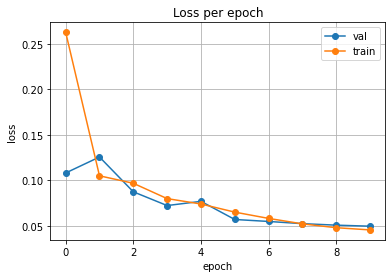

In [24]:
plt.plot(history['val_loss'], label='val', marker='o')
plt.plot( history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch'); plt.ylabel('loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()


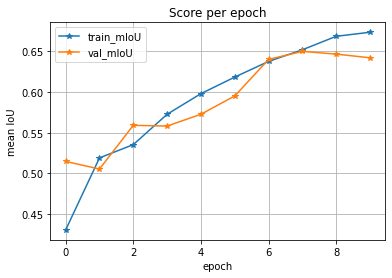

In [25]:
plt.plot(history['train_miou'], label='train_mIoU', marker='*')
plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
plt.title('Score per epoch'); plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()


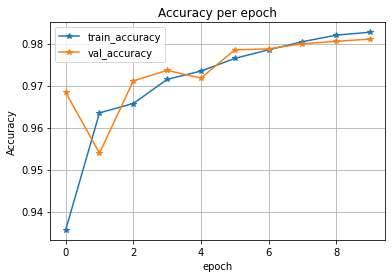

In [26]:
plt.plot(history['train_acc'], label='train_accuracy', marker='*')
plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

#### 6 epoch training

I select 6 epoch to avoid overfiting as in the graph accuracy per epoch is where the train and val accuracies converge. The masks pictures are mostly black, this is why avoid overfiting is something important in this project

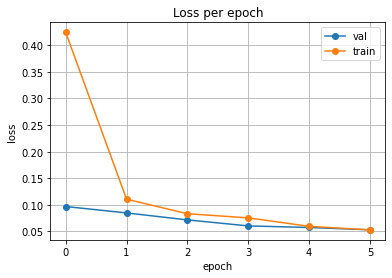

In [96]:
plt.plot(history['val_loss'], label='val', marker='o')
plt.plot( history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch'); plt.ylabel('loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()


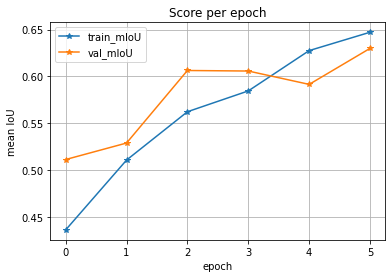

In [97]:
plt.plot(history['train_miou'], label='train_mIoU', marker='*')
plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
plt.title('Score per epoch'); plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()


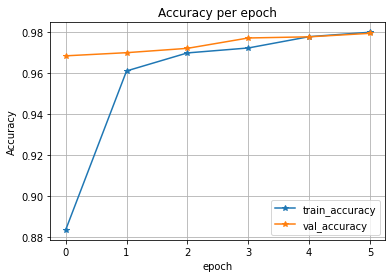

In [98]:
plt.plot(history['train_acc'], label='train_accuracy', marker='*')
plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

### Final test

In [100]:
class TestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_path, self.X.iloc[idx][0] + '.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_path, self.X.iloc[idx][0] + '.png'), cv2.IMREAD_GRAYSCALE)
        

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


In [101]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [102]:
test_set = TestDataset(os.path.join(new_test_path, 'img'), os.path.join(new_test_path, 'newmask'), X_val)

In [103]:
def test_func_graph(id):
  image, mask = test_set[id]
  pred_mask, score = predict_image_mask_miou(model, image, mask)

  mob_miou = miou_score(model, test_set)

  mob_acc = pixel_acc(model, test_set)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

#### 10 epoch training

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

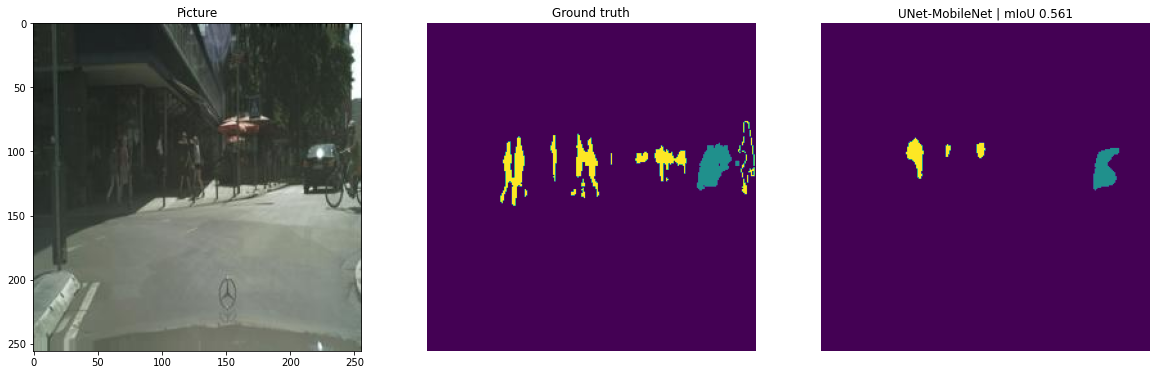

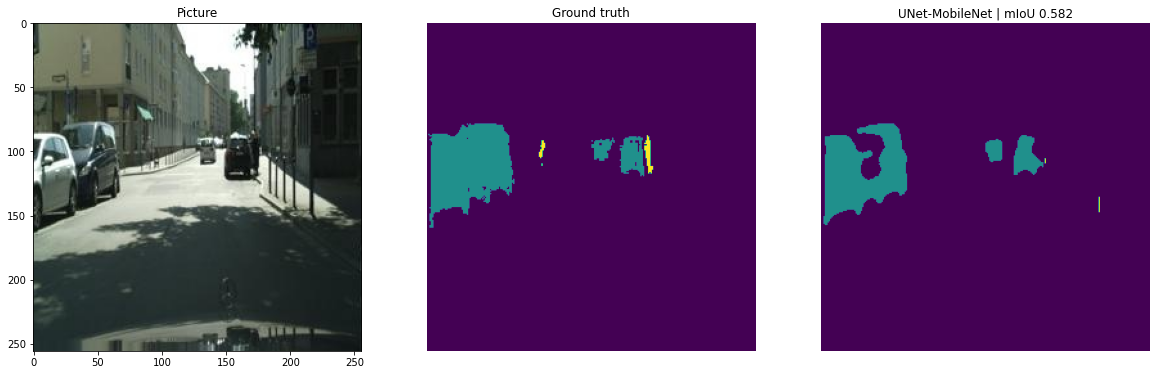

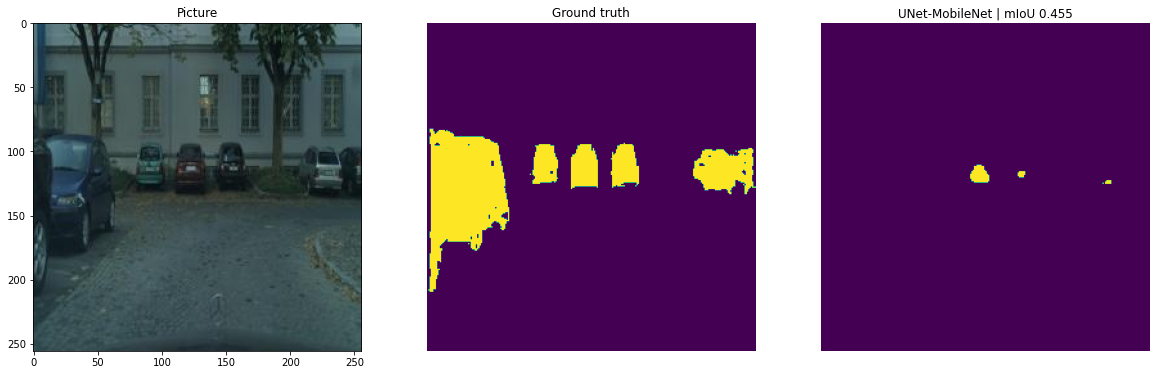

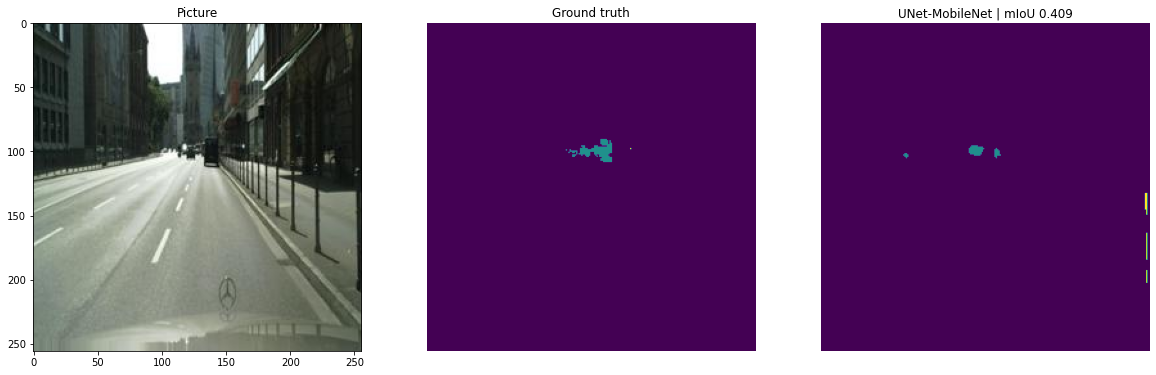

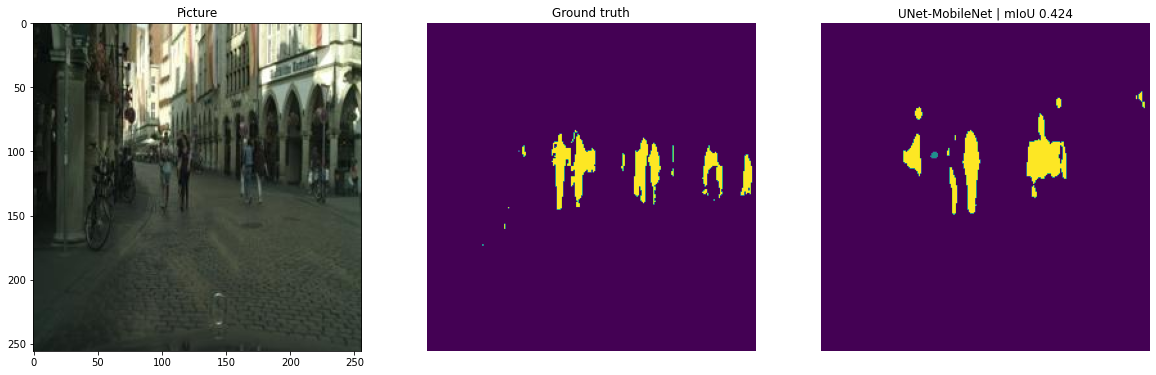

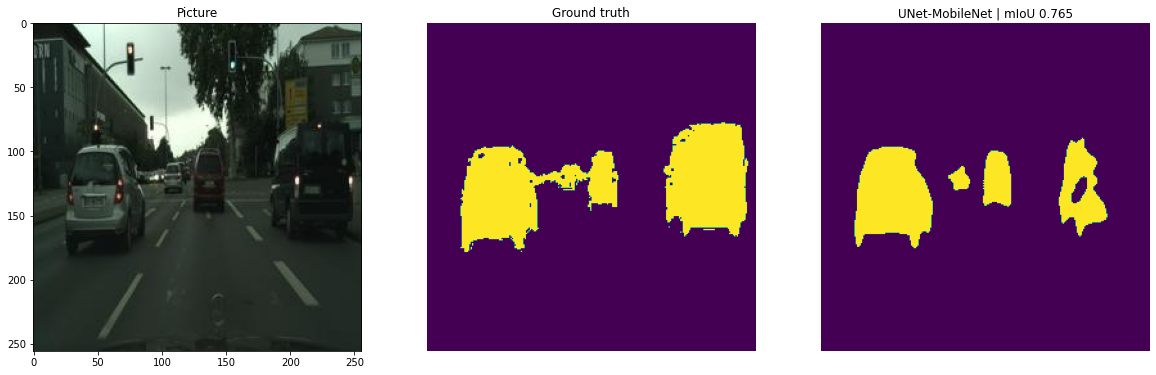

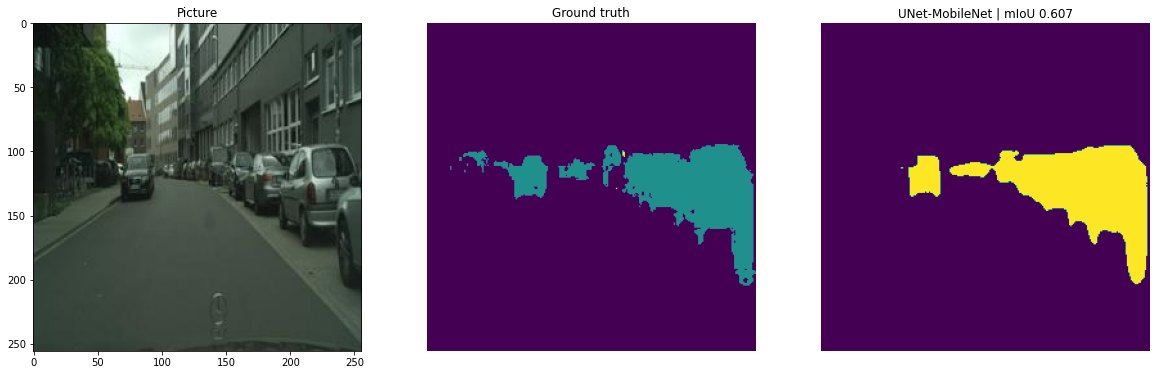

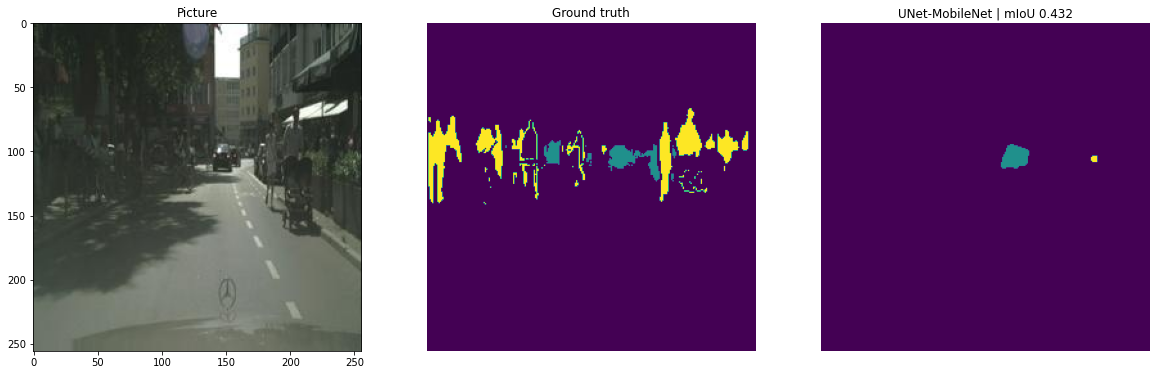

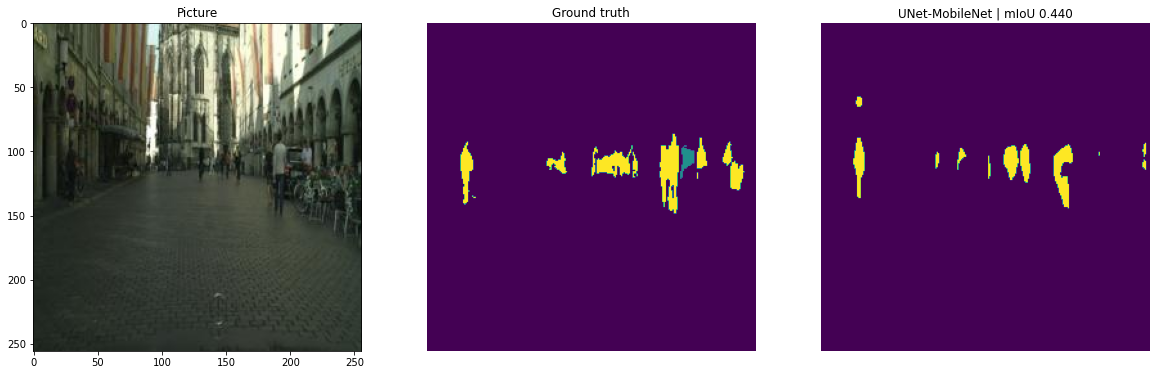

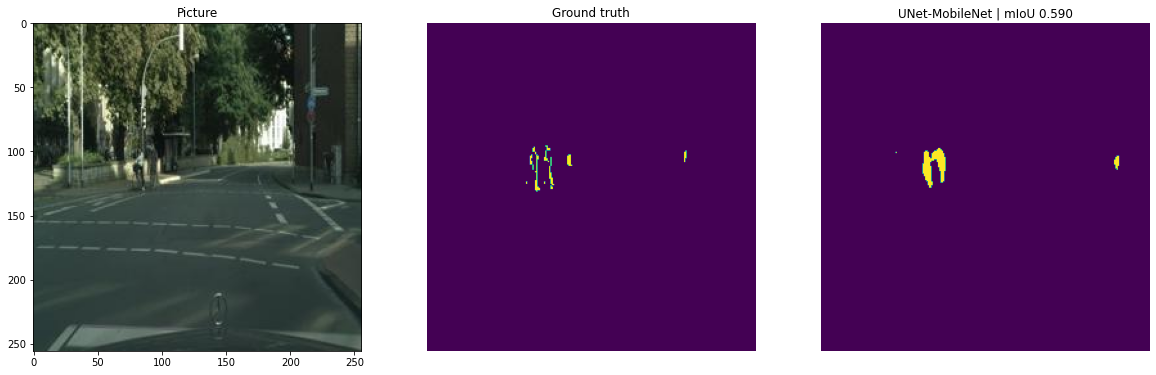

In [88]:
for i in range(10):
  test_func_graph(i)

#### 6 epoch training

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

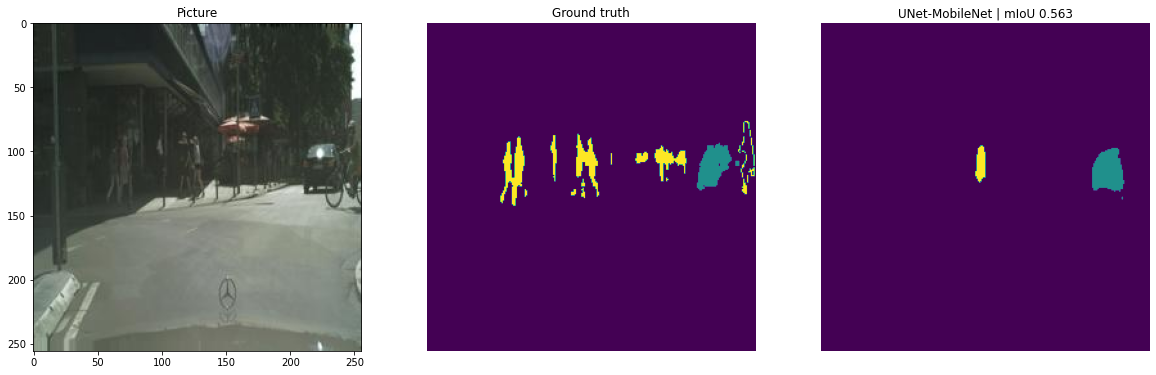

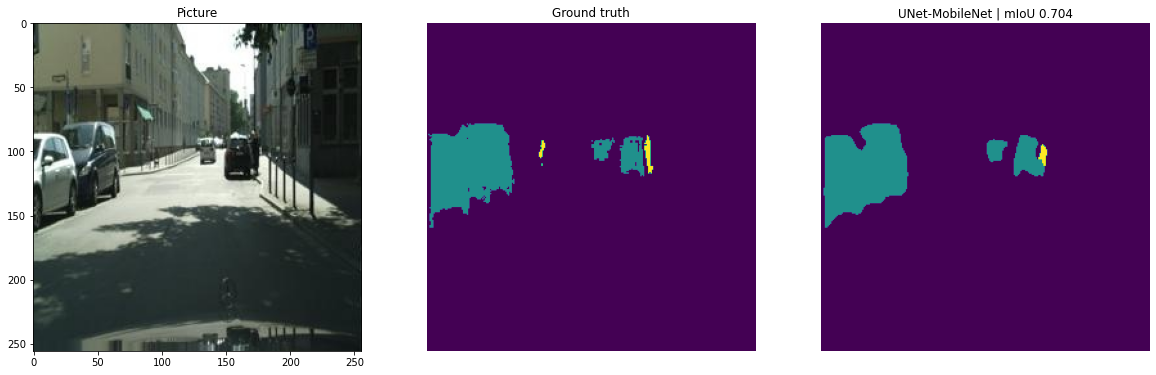

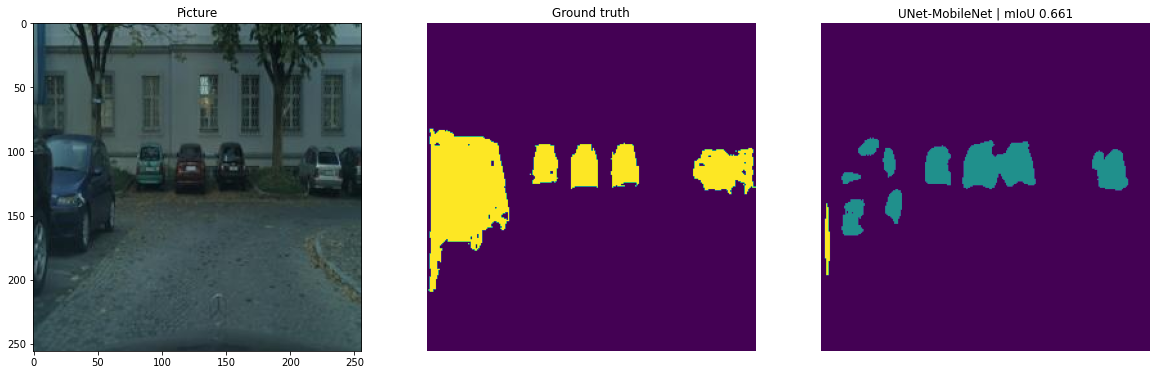

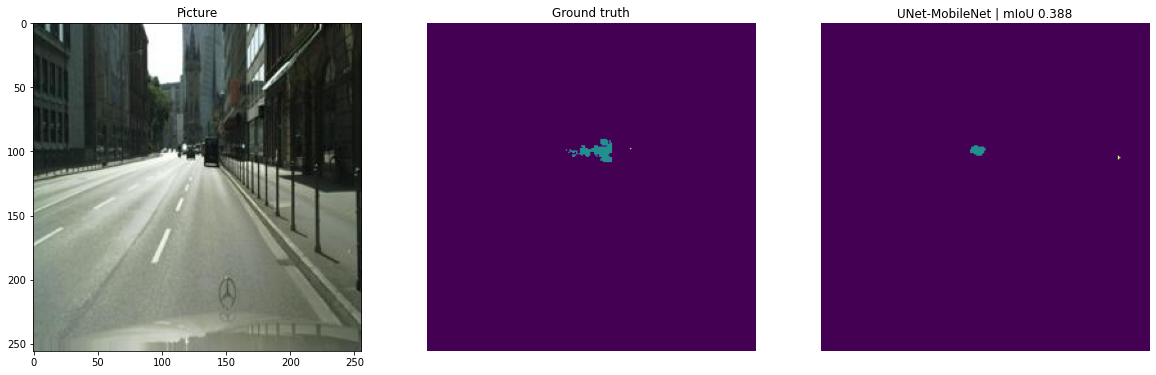

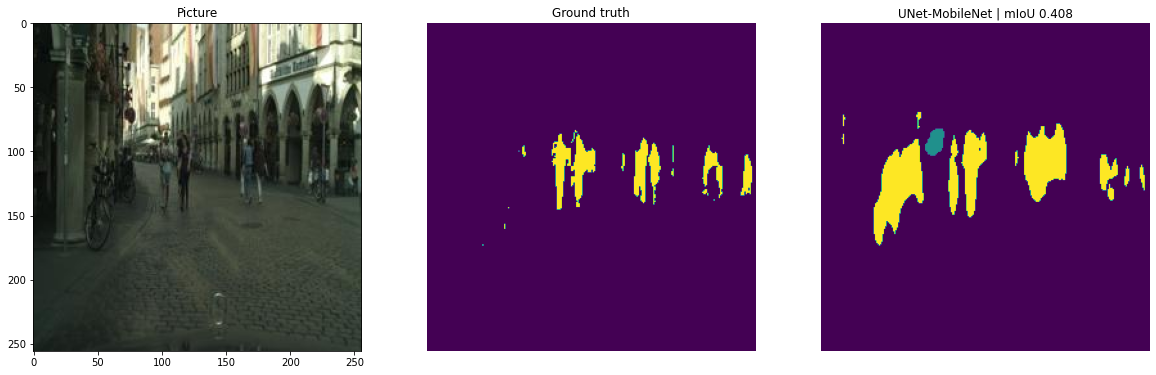

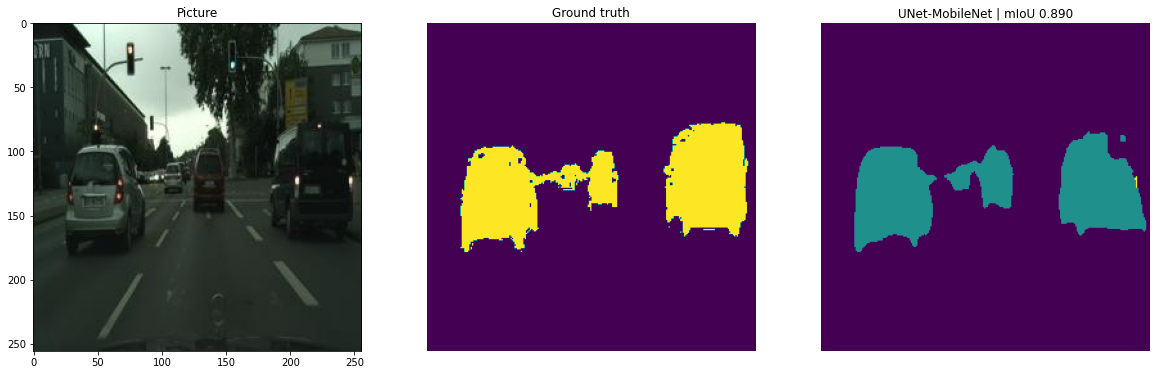

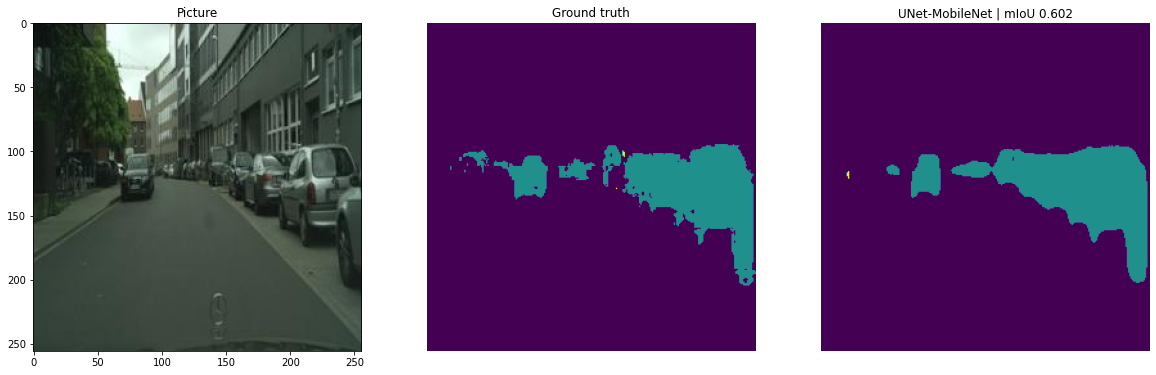

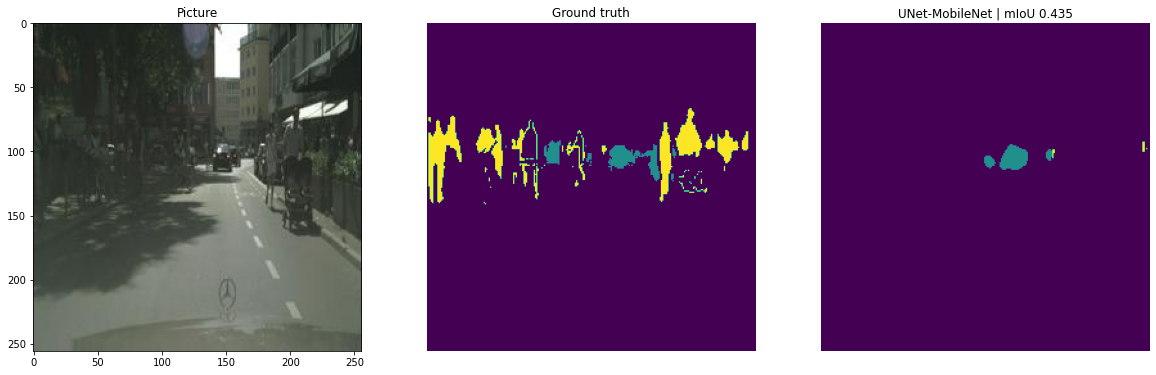

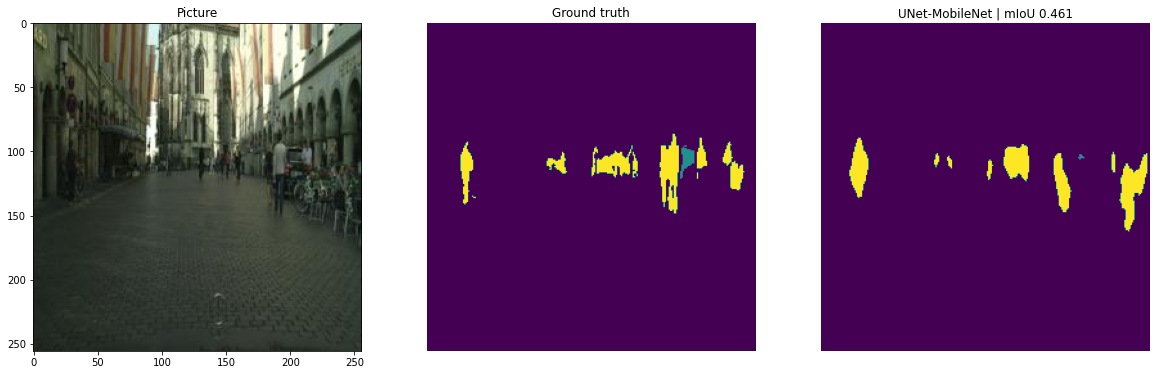

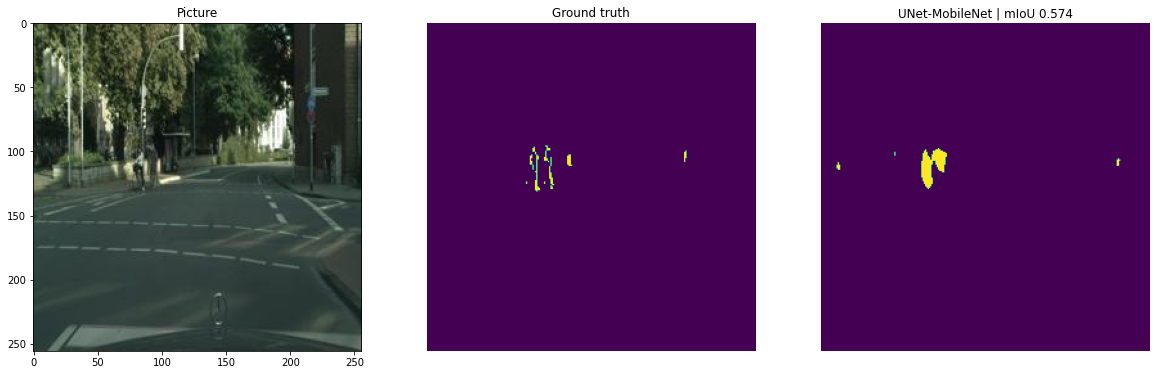

In [99]:
for i in range(10):
  test_func_graph(i)

As we can see, training with 6 and 10 epochs are different, with 10 epochs it seams to be better at segmenting cars but with less epochs (6) it is better at segmenting humans. This could be because cars takes up more space in the image compared with humans

[saved training models](https://drive.google.com/drive/folders/1_rfg695f2vJOEynmmchz-JkWgIRt626L?usp=sharing)

# Bibliography

[1]  https://nanonets.com/blog/how-to-do-semantic-segmentation-using-deep-learning/


[2] https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/discussion/80753


[3] https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch



